In [1]:
import sys
print(sys.executable)

C:\Users\kelly\anaconda3\envs\uncertainty-ml\python.exe


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import medmnist
from medmnist import INFO

In [3]:
data_flag = "dermamnist"
info = INFO[data_flag]
DataClass = getattr(medmnist, info["python_class"])

train_dataset = DataClass(split="train", download=True)
val_dataset   = DataClass(split="val", download=True)
test_dataset  = DataClass(split="test", download=True)

x_train, y_train = train_dataset.imgs, train_dataset.labels
x_val, y_val     = val_dataset.imgs, val_dataset.labels
x_test, y_test   = test_dataset.imgs, test_dataset.labels

print("Raw shapes:")
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val  :", x_val.shape,   "y_val  :", y_val.shape)
print("x_test :", x_test.shape,  "y_test :", y_test.shape)

num_classes = len(info["label"])
print("num_classes:", num_classes)

Raw shapes:
x_train: (7007, 28, 28, 3) y_train: (7007, 1)
x_val  : (1003, 28, 28, 3) y_val  : (1003, 1)
x_test : (2005, 28, 28, 3) y_test : (2005, 1)
num_classes: 7


In [4]:
# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Ensure channel dimension exists: (N,28,28) -> (N,28,28,1)
if x_train.ndim == 3:
    x_train = x_train[..., None]
    x_val   = x_val[..., None]
    x_test  = x_test[..., None]

# Labels come as shape (N,1). Convert to (N,)
y_train = y_train.squeeze()
y_val   = y_val.squeeze()
y_test  = y_test.squeeze()

# One-hot encode for categorical cross-entropy
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val, num_classes)
y_test_oh  = keras.utils.to_categorical(y_test, num_classes)

print("Processed shapes:")
print("x_train:", x_train.shape, "y_train_oh:", y_train_oh.shape)
print("x_val  :", x_val.shape,   "y_val_oh  :", y_val_oh.shape)
print("x_test :", x_test.shape,  "y_test_oh :", y_test_oh.shape)

Processed shapes:
x_train: (7007, 28, 28, 3) y_train_oh: (7007, 7)
x_val  : (1003, 28, 28, 3) y_val_oh  : (1003, 7)
x_test : (2005, 28, 28, 3) y_test_oh : (2005, 7)


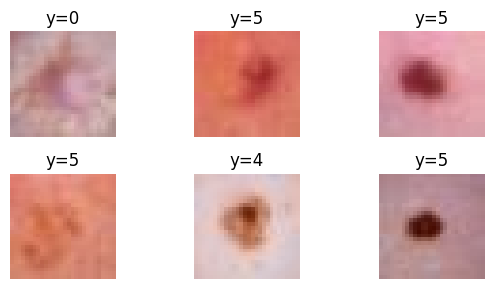

In [5]:
plt.figure(figsize=(6,3))
for i in range(6):
    plt.subplot(2,3,i+1)
    # grayscale image -> squeeze channel
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(f"y={y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
def build_cnn(input_shape, num_classes: int, dropout_rate: float = 0.3):
    inputs = keras.Input(shape=input_shape)  # e.g. (28,28,1)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_cnn(input_shape=x_train.shape[1:], num_classes=num_classes, dropout_rate=0.3)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,831 (1.61 MB)

 Trainable params: 421,831 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    x_train, y_train_oh,
    validation_data=(x_val, y_val_oh),
    epochs=15,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6675 - loss: 1.0790 - val_accuracy: 0.6690 - val_loss: 0.9751
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6715 - loss: 0.9364 - val_accuracy: 0.6740 - val_loss: 0.8854
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6846 - loss: 0.8905 - val_accuracy: 0.6730 - val_loss: 0.8804
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6905 - loss: 0.8672 - val_accuracy: 0.6740 - val_loss: 0.8287
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.6964 - loss: 0.8368 - val_accuracy: 0.6740 - val_loss: 0.8382
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7032 - loss: 0.8063 - val_accuracy: 0.7159 - val_loss: 0.8008
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7134 - loss: 0.7878 - val_accuracy: 0.7228 - val_loss: 0.7688
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7189 - loss: 0.7551 - val_accuracy: 0.7149 - v

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test_oh, verbose=0)
print("Test accuracy:", test_acc)

# Save baseline model
model.save("../data/baseline_model.keras")
print("Saved to ../data/baseline_model.keras")

Test accuracy: 0.7381545901298523
Saved to ../data/baseline_model.keras


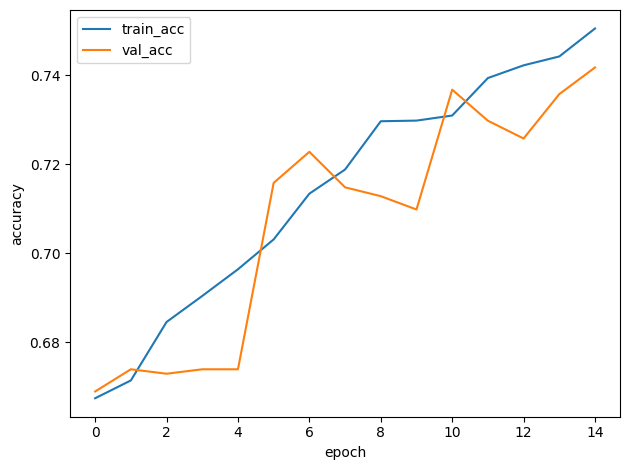

In [9]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/baseline_training_curve.png")
plt.show()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      0.484     0.227     0.309        66
           1      0.410     0.553     0.471       103
           2      0.536     0.436     0.481       220
           3      0.000     0.000     0.000        23
           4      0.548     0.103     0.174       223
           5      0.802     0.950     0.870      1341
           6      0.625     0.517     0.566        29

    accuracy                          0.738      2005
   macro avg      0.486     0.398     0.410      2005
weighted avg      0.702     0.738     0.696      2005

[[  15   23   10    0    1   16    1]
 [   0   57   14    0    1   27    4]
 [   7   12   96    0    5  100    0]
 [   2   12    2    0    0    7    0]
 [   6    7   28    1   23  156    2]
 [   1   23   29    0   12 1274    2]
 [   0    5    0    0    0    9   15]]
